In [1]:
%matplotlib inline
import math as m
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from SAMPEX_functions import read_counts as read
from SAMPEX_functions import mb_finder, read_days, mb_magnitude, iso_calculator, OrbAtt_augment
import pandas as pd
import os
import pathlib
import string
import datetime

In [2]:
# defining files
storms = ['1993047-1993053', '1993067-1993069', '1993070-1993071', '1993093-1993099', '1993127-1993133', '1993254-1993260', \
          '1993280-1993286', '1993306-1993312', '1993335-1993340']

del storms[4], storms[-1]

# defining month
month_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

0
(56,)
(56,)
14.0
1
(24,)
(24,)
7.0
2
(16,)
(16,)
-17.0
3
(56,)
(56,)
2.0
4
(56,)
(56,)
16.0
5
(56,)
(56,)
8.0
6
(56,)
(56,)
19.0


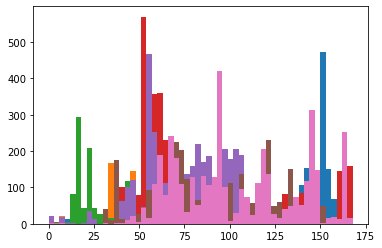

In [7]:
Dst_prestorm_1993 = np.array([])
Dst_mainphase_1993 = np.array([])
Dst_recovery_1993 = np.array([])

for storm in np.arange(len(storms)):
    # defining file
    year = storms[storm][0:4]
    start_day = storms[storm][4:7]
    num_days = int(storms[storm][12:]) - int(storms[storm][4:7]) + 1
    month = (datetime.datetime(int(year), 1, 1) + datetime.timedelta(int(start_day)-1)).month
    
    # reading in electron counts files:
    t, r1, r2, r3, r4 = read_days(year, start_day, num_days, month)
    
    # find microburst times and N_100, SSD1, SSD4 counts using algorithm
    t_microburst, N_100_microburst, r1_microburst, r4_microburst, mb_index, MB_mask, N_100, A_500 = mb_finder(t, r1, r2, r3, r4)

    BG_mask = ~MB_mask
    # calculation of the isotropy indices of electron counts
    iso_indices_MB = iso_calculator(r1[MB_mask], r4[MB_mask])
    iso_indices_BG = iso_calculator(r1[BG_mask], r4[BG_mask])


    # reading in magnetosphere indices
    directory = 'E:\SAMPEX_Data\\'
    file = 'mag_indices_' + month_list[month-1] + year + start_day + '.csv'
    Mag_Indices = pd.read_csv(directory + file, header = 0, comment = '#')

    AE_indices = Mag_Indices['5-M_AE_nT'].values
    Dst_indices = Mag_Indices['SYM/H_INDEX_nT'].values

    t_str = Mag_Indices['EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ'].values
    t_mag = np.array([])

    for i in np.arange(len(t_str)):
        if t_str[i][5:7] != t_str[0][5:7]:
            days_in_month = input('Days in the first month: ')
            break
    
    for i in np.arange(len(t_str)):
        if t_str[i][5:7] == t_str[0][5:7]:
            t_i = (int(t_str[i][8:10])-int(t_str[0][8:10])) * 86400 + int(t_str[i][11:13]) * 3600 + int(t_str[i][14:16]) * 60
        elif t_str[i][5:7] != t_str[0][5:7]:
            t_i = (int(days_in_month) + int(t_str[i][8:10])-int(t_str[0][8:10])) * 86400 + int(t_str[i][11:13]) * 3600 + \
            int(t_str[i][14:16]) * 60
        t_mag = np.append(t_mag, t_i)
        
    # find _ hr average the AE/Dst indices
    bin_size = 3              # in hours
    interval = 24*num_days    # in hours

    t_per3hrs = np.arange(0, interval*12, bin_size*12)
    index_per3hrs = np.arange(bin_size*12-1, interval*12, bin_size*12)

    AE_series = pd.Series(AE_indices)
    Dst_series = pd.Series(Dst_indices)
    AE_per3hrs = np.array(AE_series.rolling(bin_size*12, center=False).max())[index_per3hrs]
    Dst_per3hrs = np.array(Dst_series.rolling(bin_size*12, center=False).min())[index_per3hrs]
    
    # categorize Dst indices
    t_max = t_per3hrs[Dst_per3hrs == np.max(Dst_per3hrs)]; t_Dmax = [t_max] if isinstance(t_max, int) else t_max
    t_min = t_per3hrs[Dst_per3hrs == np.min(Dst_per3hrs)]; t_Dmin = [t_min] if isinstance(t_min, int) else t_min

    t_prestorm = t_per3hrs[t_per3hrs <= t_Dmax[0]]
    Dst_prestorm = Dst_per3hrs[t_per3hrs <= t_Dmax[0]]
    t_mainphase = t_per3hrs[(t_per3hrs >= t_Dmax[0]) & (t_per3hrs <= t_Dmin[0])]
    Dst_mainphase = Dst_per3hrs[(t_per3hrs >= t_Dmax[0]) & (t_per3hrs <= t_Dmin[0])]
    t_recovery = t_per3hrs[t_per3hrs >= t_Dmin[0]]
    Dst_recovery = Dst_per3hrs[t_per3hrs >= t_Dmin[0]]
    
    # determine microburst frequency (using histogram)
    MBfreq_per3hrs = np.array(plt.hist(t_microburst/3600, bins=[bin_size*i for i in range(int(interval/bin_size)+1)]))[0];
    
    # add to previous weeks' data
    AE_per3hrs_1993 = np.append(AE_per3hrs_1993, AE_per3hrs)
    Dst_prestorm_1993 = np.append(Dst_prestorm_1993, Dst_prestorm)
    Dst_mainphase_1993 = np.append(Dst_mainphase_1993, Dst_mainphase)
    Dst_recovery_1993 = np.append(Dst_recovery_1993, Dst_recovery)
    
    MBfreq_per3hrs_1993 = np.append(MBfreq_per3hrs_1993, MBfreq_per3hrs)
    MBfreq_prestorm_1993 = np.append(MBfreq_prestorm_1993, MBfreq_per3hrs[t_per3hrs <= t_Dmax[0]])
    MBfreq_mainphase_1993 = np.append(MBfreq_mainphase_1993, MBfreq_per3hrs[(t_per3hrs >= t_Dmax[0]) & (t_per3hrs <= t_Dmin[0])])
    MBfreq_recovery_1993 = np.append(MBfreq_recovery_1993, MBfreq_per3hrs[t_per3hrs >= t_Dmin[0]])

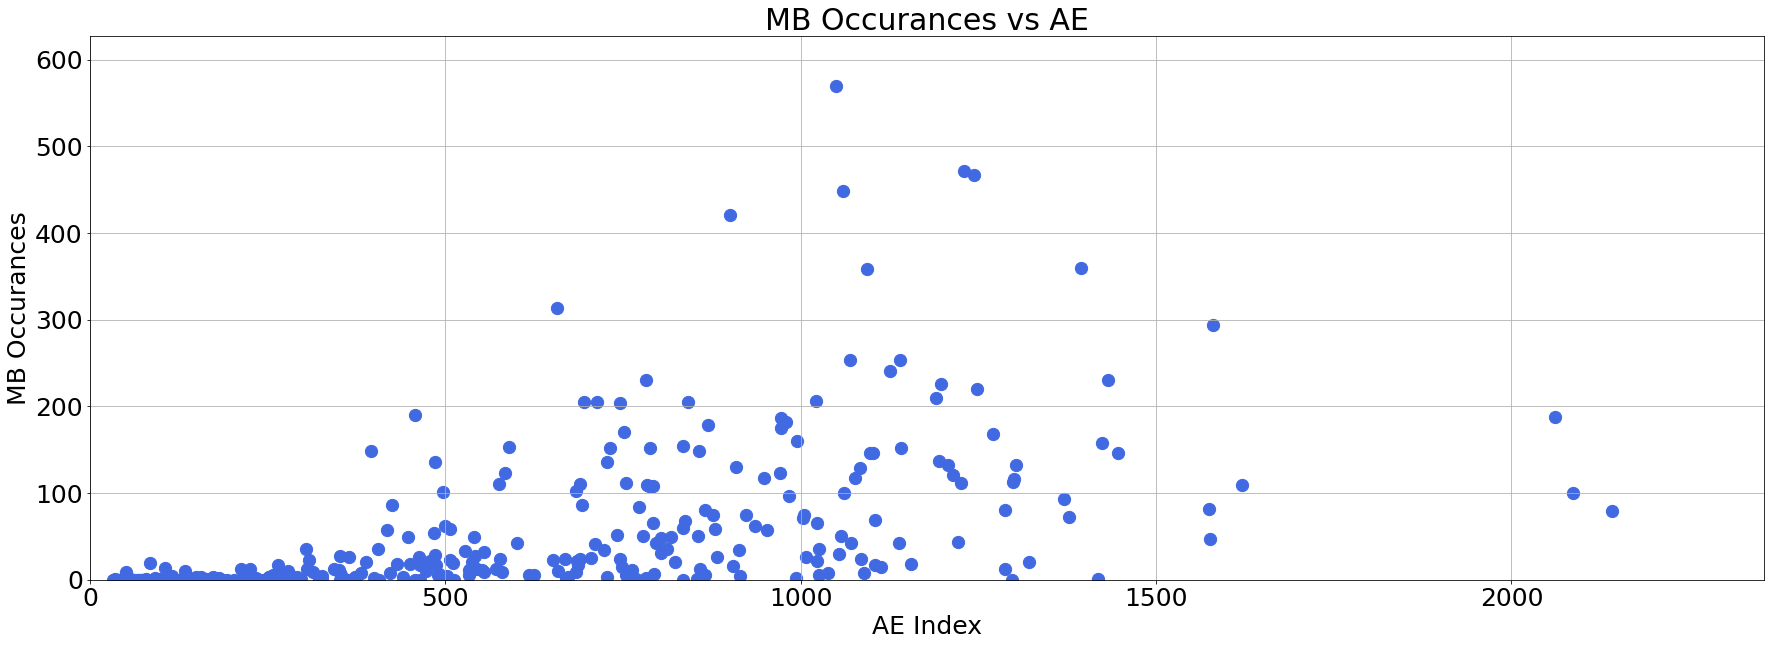

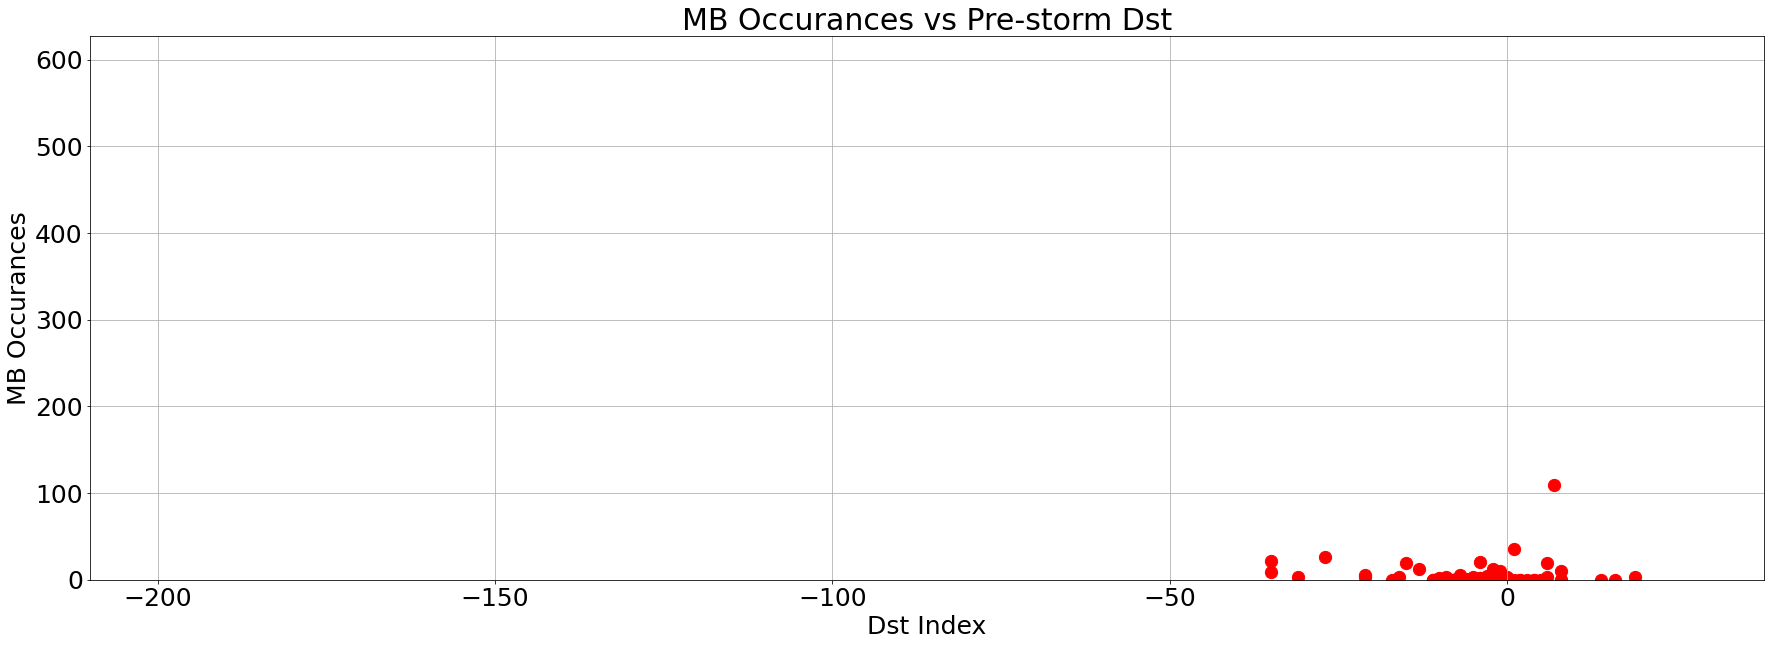

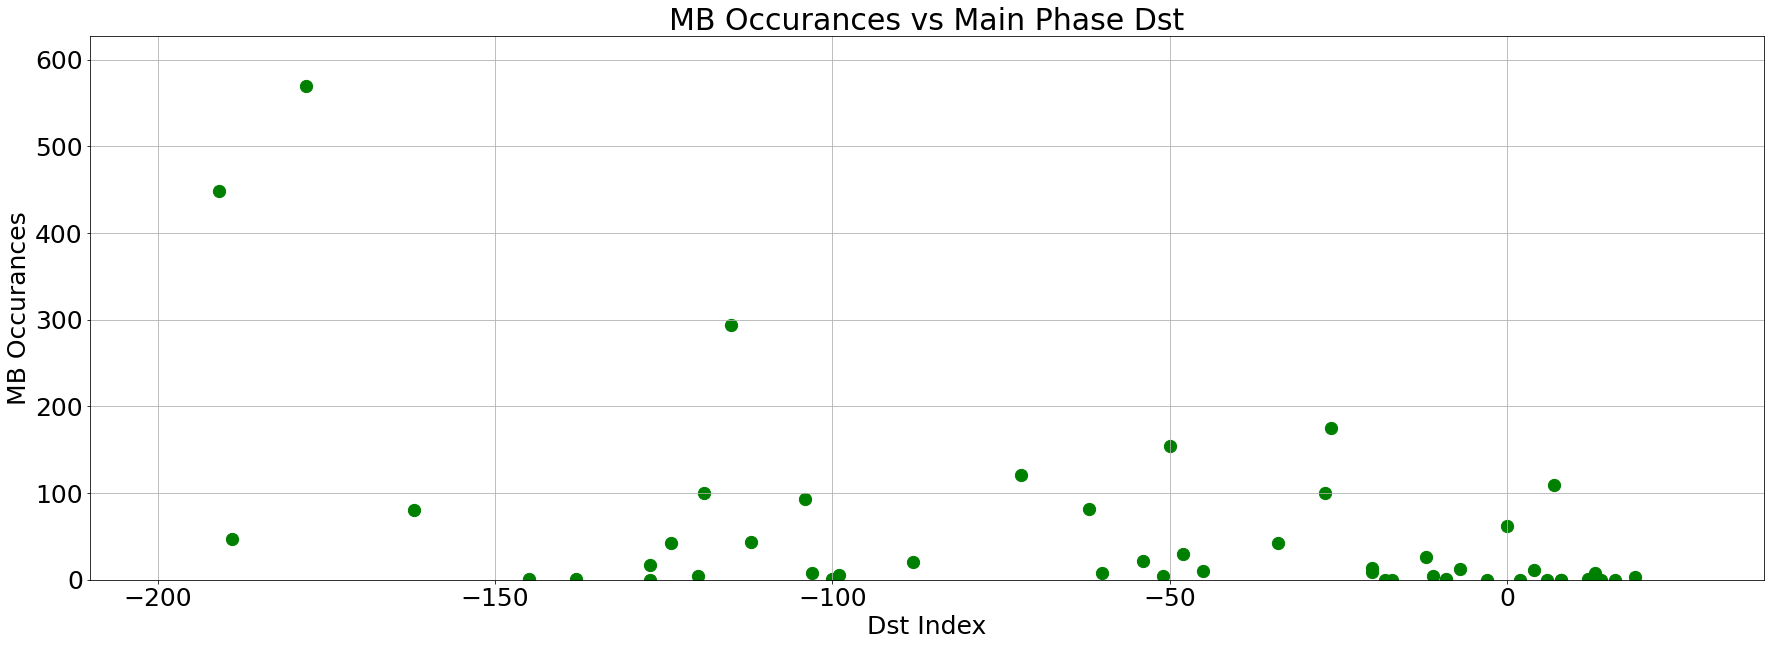

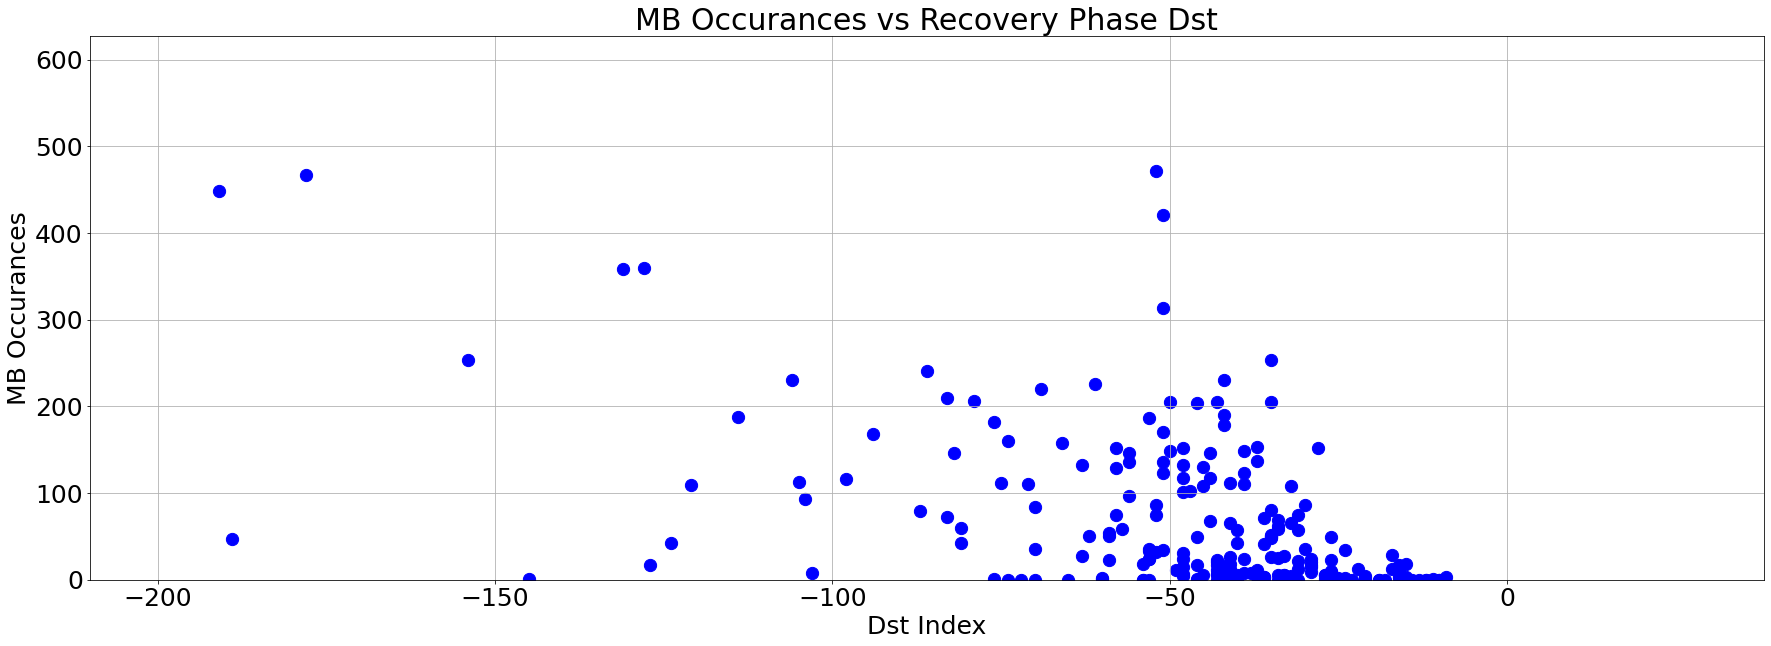

In [8]:
plt.figure(figsize = (30,10))
plt.title(f'MB Occurances vs AE', fontsize = 30)
plt.scatter(AE_per3hrs_1993, MBfreq_per3hrs_1993, s=150, c='royalblue')
plt.ylim(0, np.max(MBfreq_per3hrs_1993)+np.max(MBfreq_per3hrs_1993)/10)
plt.xlim(0, np.max(AE_per3hrs_1993)+np.max(AE_per3hrs_1993)/10)
plt.xlabel('AE Index', fontsize = 25)
plt.ylabel('MB Occurances', fontsize = 25)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.grid(True)
plt.show()

plt.figure(figsize = (30,10))
plt.title(f'MB Occurances vs Pre-storm Dst', fontsize = 30)
plt.scatter(Dst_prestorm_1993, MBfreq_prestorm_1993, s=150, c='red')
plt.ylim(0, np.max(MBfreq_per3hrs_1993)+np.max(MBfreq_per3hrs_1993)/10)
plt.xlim(np.min(Dst_mainphase_1993)-np.abs(np.min(Dst_mainphase_1993)/10), np.max(Dst_mainphase_1993)+np.abs(np.min(Dst_mainphase_1993)/10))
plt.xlabel('Dst Index', fontsize = 25)
plt.ylabel('MB Occurances', fontsize = 25)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.grid(True)
plt.show()

plt.figure(figsize = (30,10))
plt.title(f'MB Occurances vs Main Phase Dst', fontsize = 30)
plt.scatter(Dst_mainphase_1993, MBfreq_mainphase_1993, s=150, c='green')
plt.ylim(0, np.max(MBfreq_per3hrs_1993)+np.max(MBfreq_per3hrs_1993)/10)
plt.xlim(np.min(Dst_mainphase_1993)-np.abs(np.min(Dst_mainphase_1993)/10), np.max(Dst_mainphase_1993)+np.abs(np.min(Dst_mainphase_1993)/10))
plt.xlabel('Dst Index', fontsize = 25)
plt.ylabel('MB Occurances', fontsize = 25)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.grid(True)
plt.show()

plt.figure(figsize = (30,10))
plt.title(f'MB Occurances vs Recovery Phase Dst', fontsize = 30)
plt.scatter(Dst_recovery_1993, MBfreq_recovery_1993, s=150, c='blue')
plt.ylim(0, np.max(MBfreq_per3hrs_1993)+np.max(MBfreq_per3hrs_1993)/10)
plt.xlim(np.min(Dst_mainphase_1993)-np.abs(np.min(Dst_mainphase_1993)/10), np.max(Dst_mainphase_1993)+np.abs(np.min(Dst_mainphase_1993)/10))
plt.xlabel('Dst Index', fontsize = 25)
plt.ylabel('MB Occurances', fontsize = 25)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.grid(True)
plt.show()